Python Port of PheCAP Algorithm

Replicate the process in main.R.

In [1]:
import sys

sys.path.append('../src')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from pyphecap.plotting import plot_roc_curves
from pyphecap.predict import predict_phenotype, validate_phenotyping_model
from pyphecap.training import train_phenotyping_model
from pyphecap.feature_extraction import run_feature_extraction
from pyphecap.phecap_data import add_validation_column, Data
from pyphecap.surrogate import Surrogates, Surrogate

In [3]:
ehr_data = pd.read_csv('../data/ehr_data.csv')  # read sample data output from R
ehr_data.shape

(10000, 590)

In [4]:
# gold standard
ehr_data[~pd.isnull(ehr_data.label)]['label'].value_counts()

1.0    119
0.0     62
Name: label, dtype: int64

In [5]:
add_validation_column(ehr_data)
data = Data(
    ehr_data,
    'healthcare_utilization',
    'label',
    'validation',
)

In [6]:
surrogates = Surrogates(
    Surrogate("main_ICD"),
    Surrogate("main_NLP"),
    Surrogate("main_ICD", "main_NLP"),
)

In [7]:
selected_features = run_feature_extraction(data, surrogates)
selected_features

['main_NLP',
 'main_ICD',
 'NLP6',
 'NLP56',
 'NLP160',
 'NLP161',
 'NLP306',
 'NLP309',
 'NLP403',
 'NLP536',
 'NLP564']

In [8]:
coefficients, train_roc_auc, split_roc_auc = train_phenotyping_model(data, surrogates, selected_features)
coefficients, train_roc_auc[0], split_roc_auc[0]

([('intercept', 0.35801332282997206),
  ('main_ICD', 0.5503137673771231),
  ('main_NLP', 0.8721062860979317),
  ('main_ICD__main_NLP', 0.38488509496272116),
  ('healthcare_utilization', 0.5255633910558086),
  ('NLP161', 0.4344704769686019),
  ('NLP306', 0.6526342376739821),
  ('NLP536', 0.4926048382980176),
  ('NLP564', 0.5053233179763226),
  ('NLP56', 0.5727897050732865),
  ('NLP6', 0.5231197363763531),
  ('NLP160', 0.44994816379174263),
  ('NLP309', 0.4817530445800838)],
 0.9401154401154401,
 0.8820158102766799)

In [9]:
phenotype = predict_phenotype(data, surrogates, coefficients, selected_features)
phenotype

array([ 1.41261286, 13.96978305,  4.82370411, ...,  1.09773701,
        1.00836944,  2.75220788])

In [10]:
valid_roc_auc = validate_phenotyping_model(data, surrogates, coefficients, selected_features)
valid_roc_auc[0]

0.7353479853479854

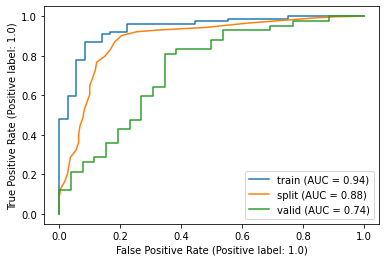

In [11]:
plot_roc_curves(train_roc_auc, split_roc_auc, valid_roc_auc)
plt.show()